# 손글씨 인식 신경망

이번에는 5층 신경망에 드롭아웃, 가중치 감소, 배치 정규화, 다양한 가중치 초기화 방식을 이용하여 안정적인 망을 구현하여 볼 것이다. 

In [2]:
import numpy as np
import random as rand
from matplotlib import pyplot as plt
from collections import OrderedDict

import sys,os
sys.path.append(os.pardir) #os.getcwd()

from scratch.dataset.mnist import load_mnist
from scratch.common.util import shuffle_dataset



### 데이터 불러오기 & 훈련/검증/시험 데이터로 구분

In [3]:

# 훈련 / 시험 데이터로 구분되어 있으므로 훈련 데이터의 일부를 검증 데이터로 하자
(x_train, t_train),(x_test, t_test) = load_mnist(normalize=True, flatten=True, one_hot_label=True)
x_train, t_train = shuffle_dataset(x_train, t_train)

validation_rate = 0.2
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

### 신경망 구현에 필요한 함수 및 객체 정의

In [4]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def relu(x):
    return max(0,x)

def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

def cross_entropy_error(y, t):
    
    if y.ndim==1: 
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    if t.size == y.size: 
        t = t.argmax(axis=1) # one-hot vector라면 레이블로 변환
        
    batch_size = y.shape[0]
    
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

def softmax(x): #출력->확률
    if x.ndim == 2:
        x = x.T;
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T
    
    x = x -np.max(x)
    return np.exp(x)/np.sum(np.exp(x))
        
        
def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y,t)

In [5]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx
    
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx


class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx
    
class Dropout: # 노드중 일부의 연결을 무작위로 끊음
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None # mask 초기화
        
    def forward(self, x, train_flg=True): 
        # 훈련시 노드를 삭제하고 시험시에는 데이터를 흘리기만 한다
        if(train_flg):
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            # *의 의미 -> Unpacking a function using positional argument
            return x * self.mask
        
        else:
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self,dout):
        # mask가 없는 곳만 통과 가능
        return dout * self.mask
    
class BatchNormalization:
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma # 확대
        self.beta = beta # 이동
        self.momentum = momentum
        self.input_shape = None
        
        self.running_mean = running_mean # 평균
        self.running_var = running_var # 분산
        
        # backward시 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None        
        
    def forward(self, x, train_flg=True): # 훈련일때만 배치놈사용
        self.input_shape = x.shape
        if(x.ndim!=2): # 4차원
            N, C, H, W = x.shape # 
            x = x.reshape(N, -1)
        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx
    

### optimizer 종류

In [6]:
class SGD:

    """확률적 경사 하강법（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 

### 신경망 구현

In [7]:
class MultiLayerNetExtend:
    """완전 연결 다층 신경망(확장판)
    가중치 감소, 드롭아웃, 배치 정규화 구현

    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    use_dropout : 드롭아웃 사용 여부
    dropout_ration : 드롭아웃 비율
    use_batchNorm : 배치 정규화 사용 여부
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0, 
                 use_dropout = False, dropout_ration = 0.5, use_batchnorm=False):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.use_dropout = use_dropout
        self.weight_decay_lambda = weight_decay_lambda
        self.use_batchnorm = use_batchnorm
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            if self.use_batchnorm:
                self.params['gamma' + str(idx)] = np.ones(hidden_size_list[idx-1])
                self.params['beta' + str(idx)] = np.zeros(hidden_size_list[idx-1])
                self.layers['BatchNorm' + str(idx)] = BatchNormalization(self.params['gamma' + str(idx)], self.params['beta' + str(idx)])
                
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()
            
            if self.use_dropout:
                self.layers['Dropout' + str(idx)] = Dropout(dropout_ration)

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화
        
        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLUを使う場合に推奨される初期値
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoidを使う場合に推奨される初期値
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)

        return x

    def loss(self, x, t, train_flg=False):
        """손실 함수를 구한다.
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블 
        """
        y = self.predict(x, train_flg)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, X, T):
        Y = self.predict(X, train_flg=False)
        Y = np.argmax(Y, axis=1)
        if T.ndim != 1 : T = np.argmax(T, axis=1)

        accuracy = np.sum(Y == T) / float(X.shape[0])
        return accuracy

    def numerical_gradient(self, X, T):
        """기울기를 구한다(수치 미분).
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_W = lambda W: self.loss(X, T, train_flg=True)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])
            
            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = numerical_gradient(loss_W, self.params['gamma' + str(idx)])
                grads['beta' + str(idx)] = numerical_gradient(loss_W, self.params['beta' + str(idx)])

        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t, train_flg=True)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.params['W' + str(idx)]
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta

        return grads


### 5층 신경망

In [77]:
max_count= 10
# train_loss_list= np.zeros((max_count,50))
# test_loss_list = np.zeros((max_count,50))
# train_acc_list = np.zeros((max_count,50))
# test_acc_list = np.zeros((max_count,50))

lr_list = np.zeros((max_count))
lambda_list = np.zeros((max_count))

input_size = 784
hidden_size_list= [100,100,100,100]
output_size = 10

for count in range(1):
    
    learning_rate = 0.009
    weight_decay = 0.00015
    
    lambda_list[count] = weight_decay
    lr_list[count] = learning_rate

    network = MultiLayerNetExtend(input_size, hidden_size_list, output_size, weight_decay_lambda=weight_decay, use_dropout = True, use_batchnorm=True)
    # input_size, hidden_size_list, output_size, activation='relu', weight_init_std='relu', weight_decay_lambda=0, 
    # use_dropout = False, dropout_ration = 0.5, use_batchnorm=False

    # 매개변수 갱신용 optimizer
    optimizer = SGD(lr = learning_rate)
    # optimizer = Adam()
    # optimizer = momentum()

    max_epochs = 5 #201
    train_size = x_train.shape[0]
    batch_size = 100 # 한 epoch는 배치를 480번 돌린것

    #train_loss_list = []
    train_acc_list = []
    test_acc_list = []

    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0

    for i in range(int(iter_per_epoch)*40):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        grads = network.gradient(x_batch, t_batch)
        optimizer.update(network.params, grads)
        
        if i % 20 == 0:
            train_loss = network.loss(x_train, t_train, train_flg=True)
            test_loss = network.loss(x_test, t_test)
            train_acc = network.accuracy(x_train, t_train)
            test_acc = network.accuracy(x_test, t_test)

            index = int(i/20)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
#             train_loss_list[count][index]=train_loss
#             test_loss_list[count][index]=test_loss
        
            if i % iter_per_epoch == 0:
                print("count: "+str(count)+ ", epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

                epoch_cnt += 1
                if epoch_cnt >= max_epochs:
                    break


count: 0, epoch:0, train acc:0.08145833333333333, test acc:0.0864
count: 0, epoch:1, train acc:0.4814375, test acc:0.4926
count: 0, epoch:2, train acc:0.6068541666666667, test acc:0.6223
count: 0, epoch:3, train acc:0.6750833333333334, test acc:0.6884
count: 0, epoch:4, train acc:0.7146458333333333, test acc:0.721


<function matplotlib.pyplot.show(close=None, block=None)>

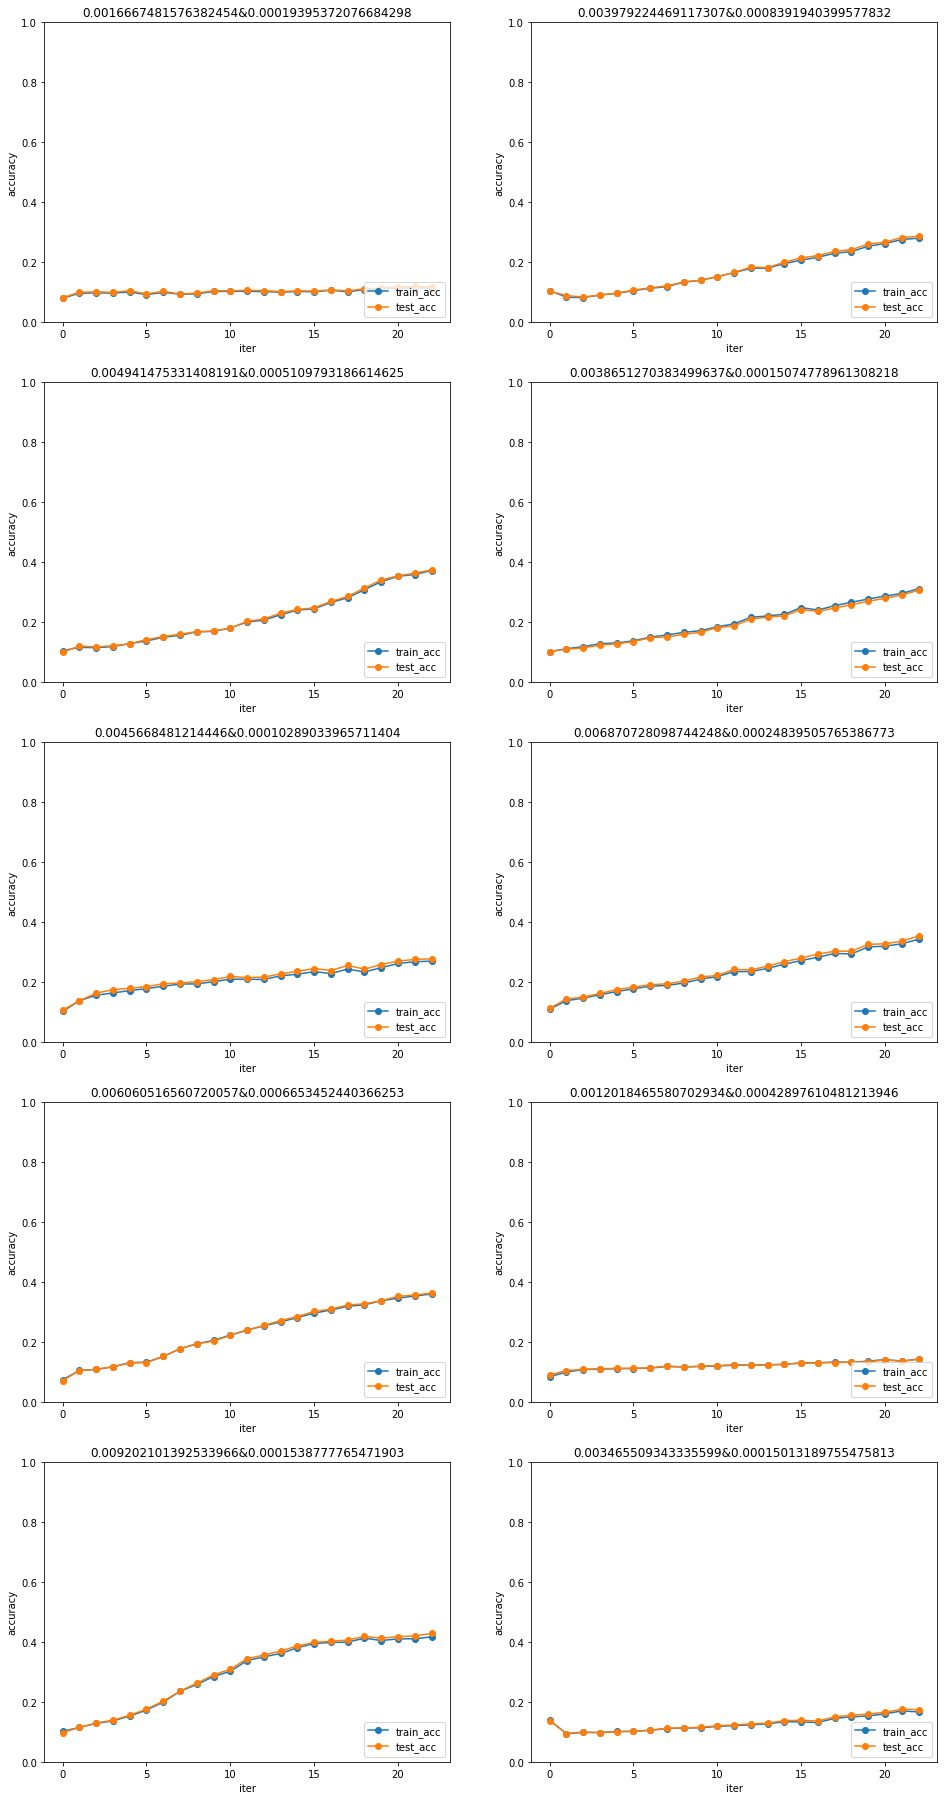

In [75]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(23)

plt.figure(figsize=(16,32))

for i in range(max_count):
    plt.subplot(5,2,i+1)
    plt.title(str(lr_list[i])+"&"+str(lambda_list[i]))
    plt.plot(x, train_acc_list[i][:23], marker='o', label = "train_acc")
    plt.plot(x, test_acc_list[i][:23], marker='o', label= "test_acc")
    plt.ylim(0,1)
    plt.xlabel("iter")
    plt.ylabel("accuracy")
    plt.legend(loc='lower right')
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

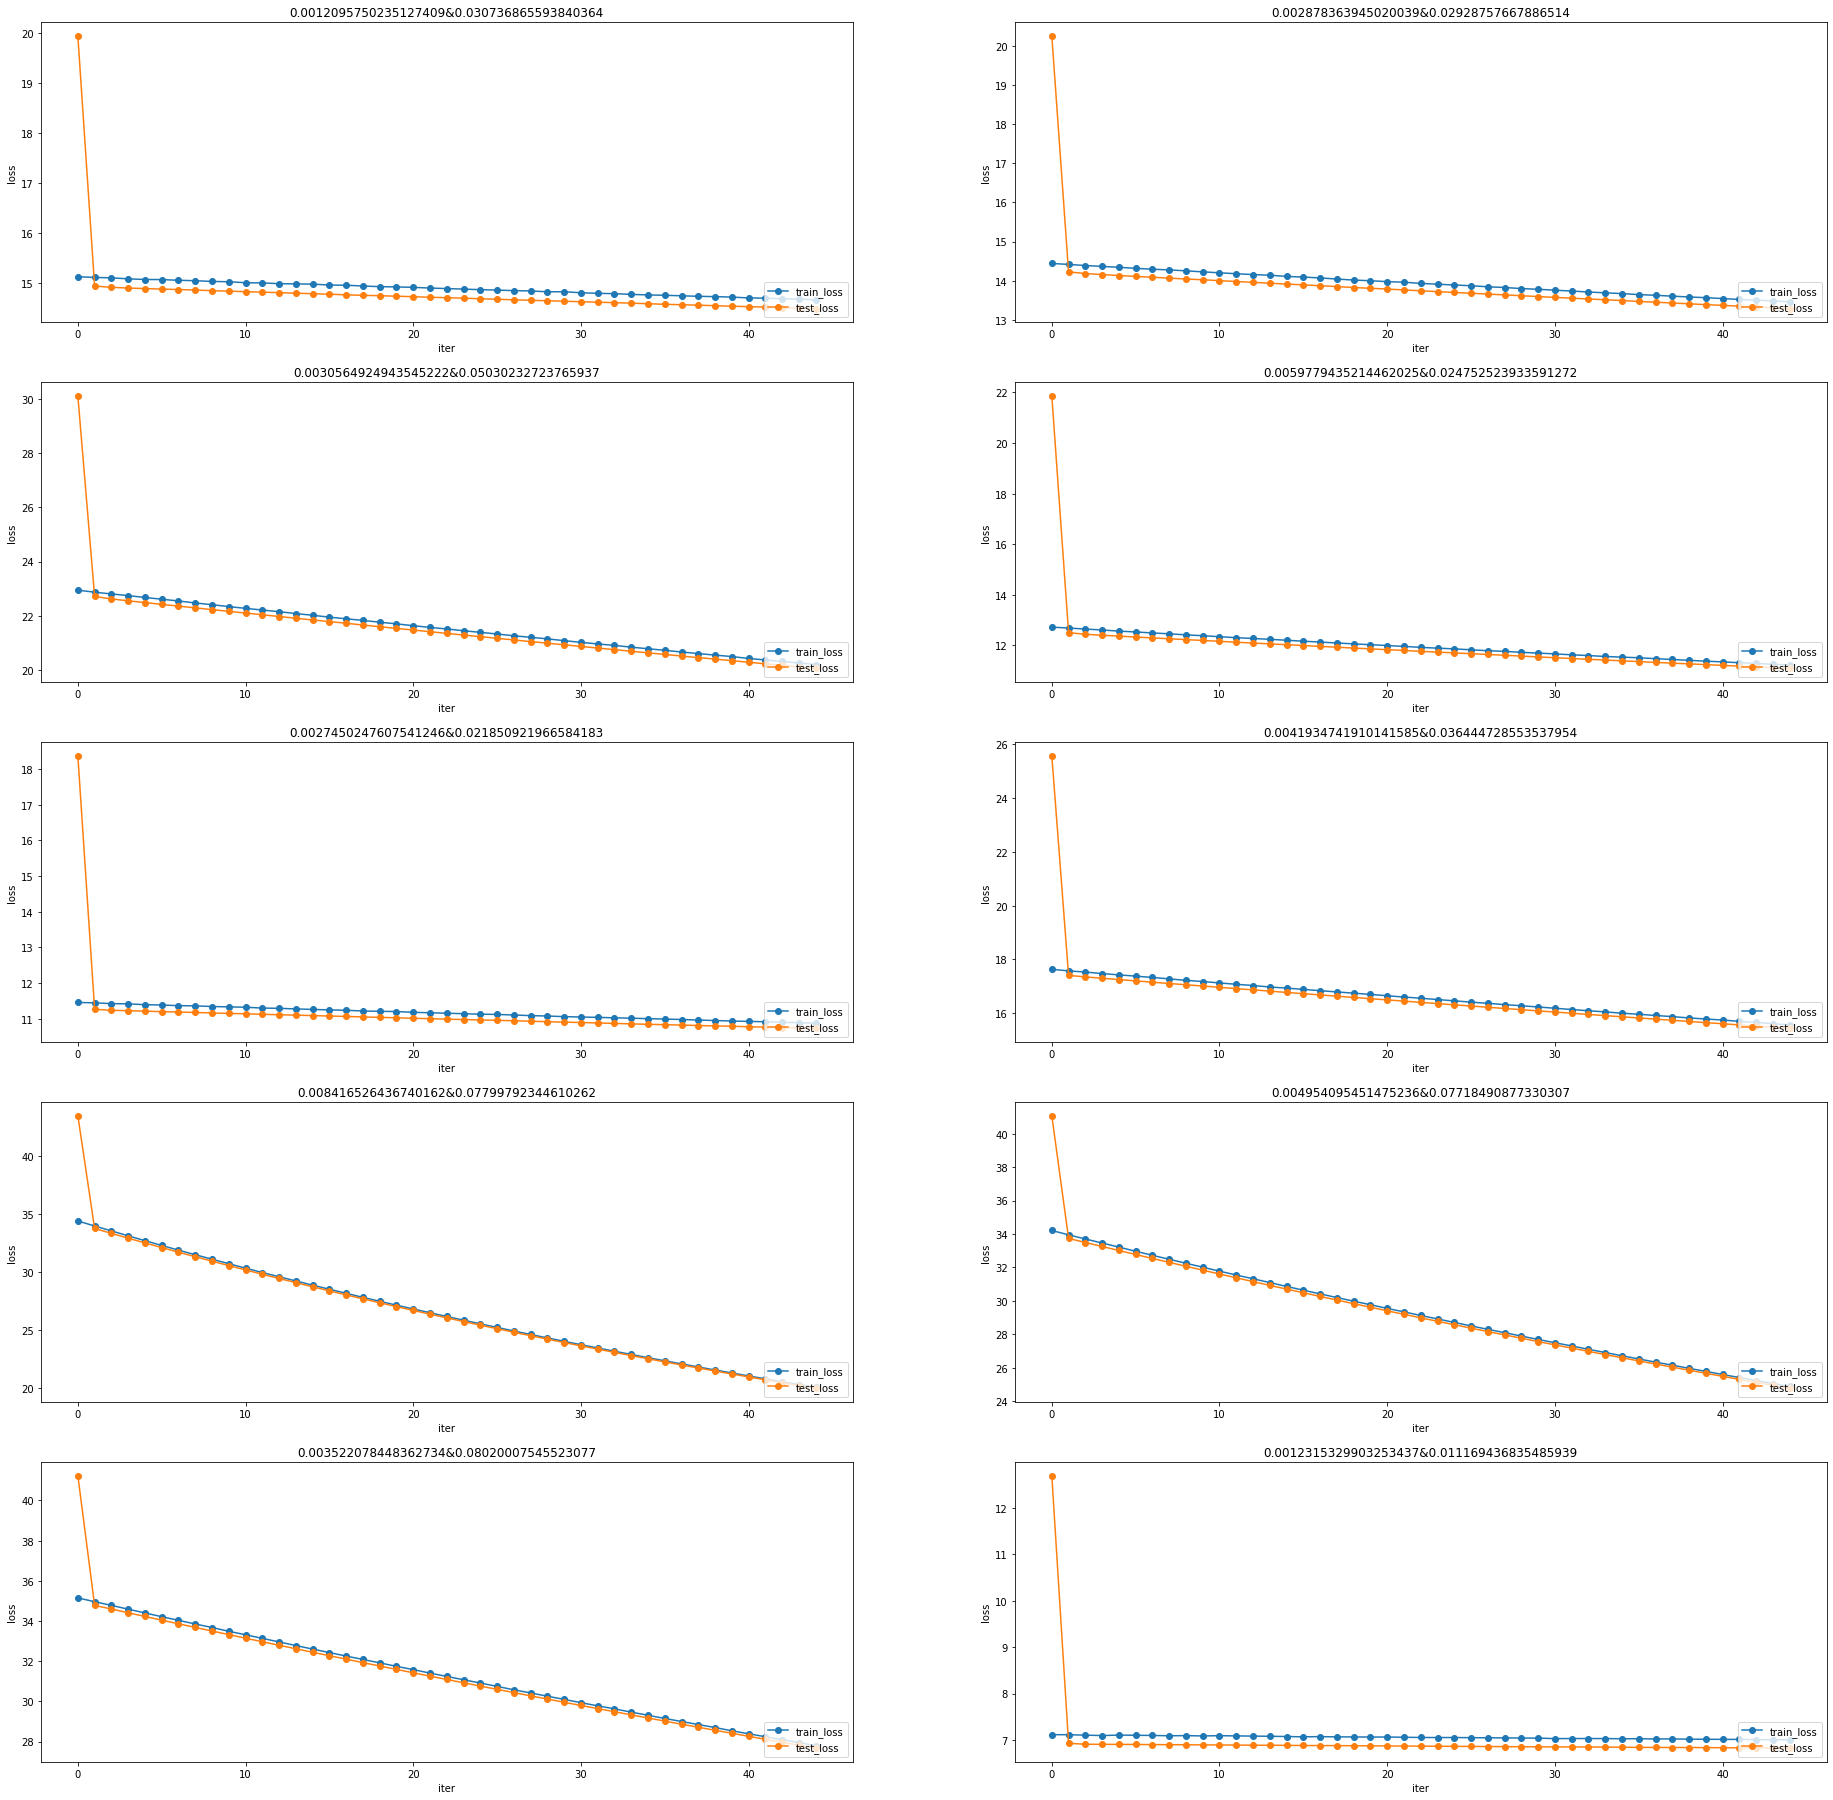

In [72]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(45)

plt.figure(figsize=(16,32))

for i in range(max_count):
    plt.subplot(5,2,i+1)
    plt.title(str(lr_list[i])+"&"+str(lambda_list[i]))
    plt.plot(x, train_loss_list[i][:45], marker='o', label = "train_loss")
    plt.plot(x, test_loss_list[i][:45], marker='o', label = "test_loss")
    plt.ylim(10,0)
    plt.xlabel("iter")
    plt.ylabel("loss")
    plt.legend(loc='lower right')
    
plt.show

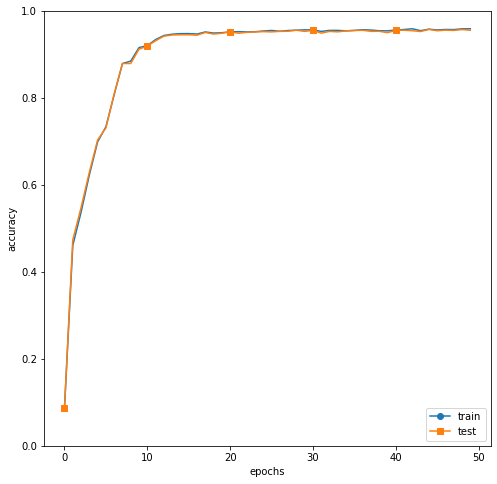

In [33]:
# accuracy 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.figure(figsize=(8,8))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


* 가중치 억제 -> train accuracy와 test accuracy의 간극을 좁히고, 훈련데이터에 오버피팅 되지 않도록 한다.(train accuracy가 1.0이 될 수 없다.)

* 드롭 아웃 -> 신경망을 따로 학습시키고 합친 효과를 준다.

* 배치 정규화 -> std조절이나 He, Xavier과 같은 매개변수 초기화 방법을 통해 활성화 값이 고르게 퍼지도록 하는 것에서 그치지 않고, 활성화 값이 고르게 퍼지도록 강제함. 활성화 함수 뒤에 위치할 수도 있지만, 위의 신경망에서는 활성화 함수 앞에 위치한다.

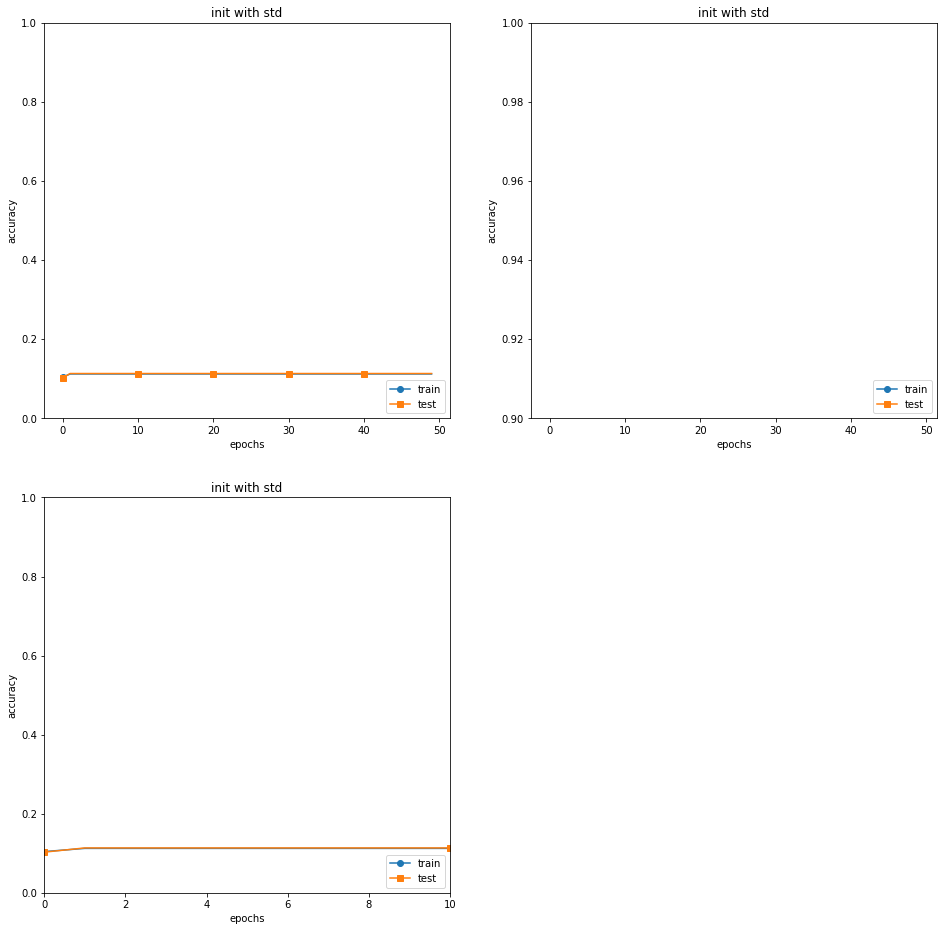

In [30]:
# 활성화 값의 초기화를 std = 0.01 로 했을때 
# 오버피팅 방지 혹은 배치 정규화 사용 x
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.figure(figsize=(16,16))

plt.subplot(2,2,1)
plt.title("init with std")
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')

plt.subplot(2,2,2)
plt.title("init with std")
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0.9, 1.0)
plt.legend(loc='lower right')

plt.subplot(2,2,3)
plt.title("init with std")
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.xlim(0,10)
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

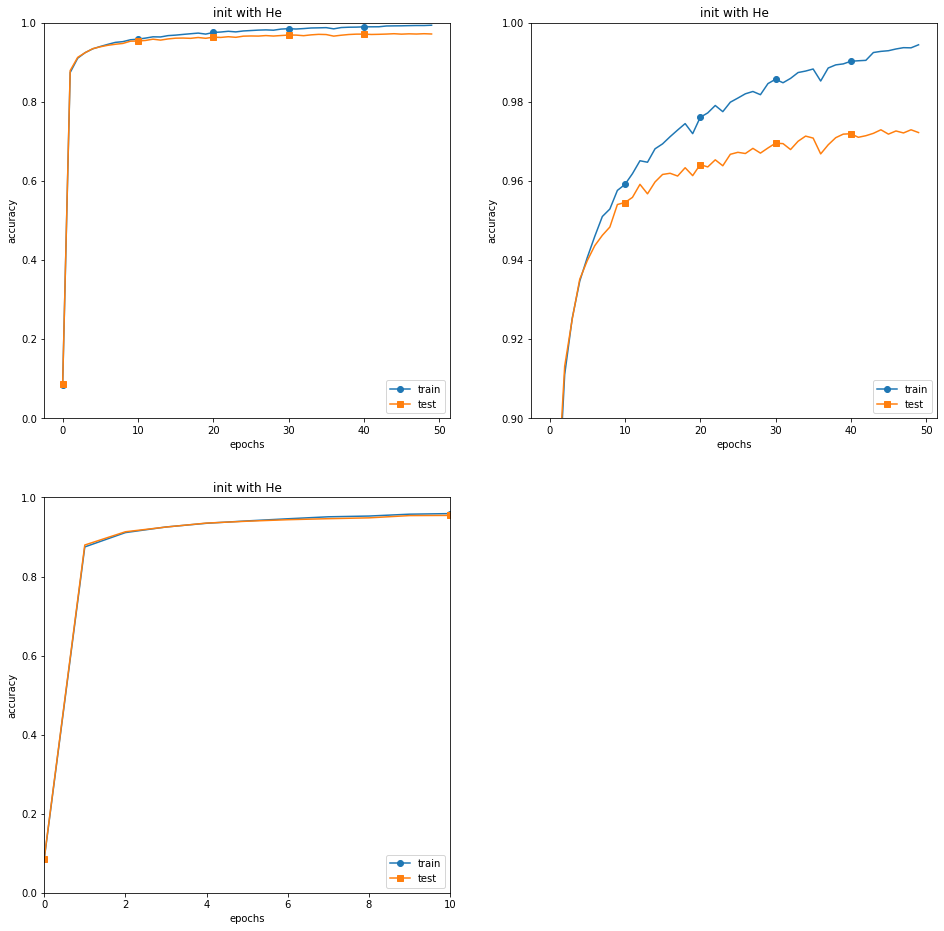

In [26]:
# 활성화 값의 초기화를 He로 했을때 
# 오버피팅 방지 혹은 배치 정규화 사용 x
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.figure(figsize=(16,16))

plt.subplot(2,2,1)
plt.title("init with He")
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')

plt.subplot(2,2,2)
plt.title("init with He")
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0.9, 1.0)
plt.legend(loc='lower right')

plt.subplot(2,2,3)
plt.title("init with He")
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.xlim(0,10)
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

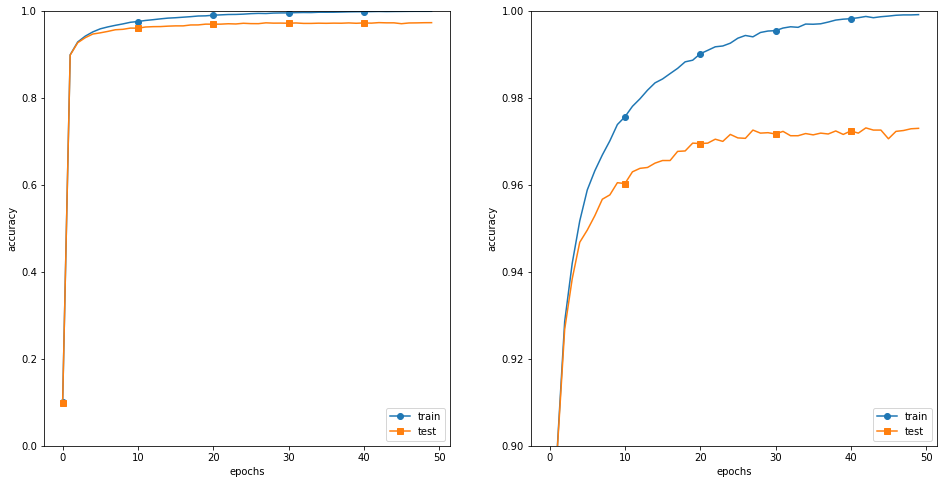

In [21]:
# Batch Normalization 사용 -> 훈련속도가 매우 빠름 하지만 train acc와 test acc의 차이가 생긴다. & train acc가 99% 이상이 된다.
# BNnetwork = MultiLayerNetExtend(input_size, hidden_size_list, output_size, activation='relu', weight_init_std='relu', weight_decay_lambda=0, use_dropout = False, dropout_ration = 0.5, use_batchnorm=True)
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)

plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0.9, 1.0)
plt.legend(loc='lower right')

plt.show()

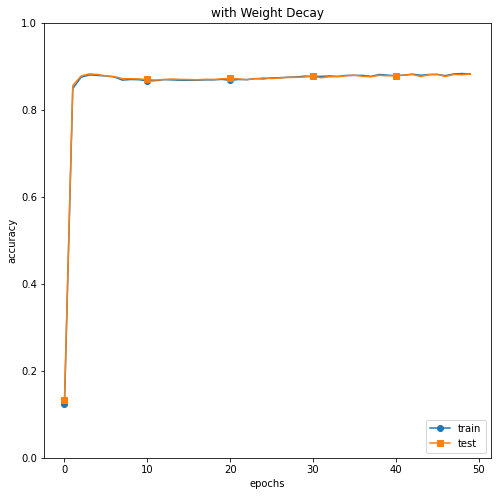

In [16]:
# 가중치 감소 사용 -> 단독 사용시 정확도가 낮아짐/ 훈련 속도가 너무.. 느림 / 오버피팅 보이지 않는듯
# WDnetwork = MultiLayerNetExtend(input_size, hidden_size_list, output_size, activation='relu', weight_init_std='relu', weight_decay_lambda=0.0, use_dropout = False, dropout_ration = 0.5, use_batchnorm=False)
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.figure(figsize=(8,8))
plt.title("with Weight Decay")
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

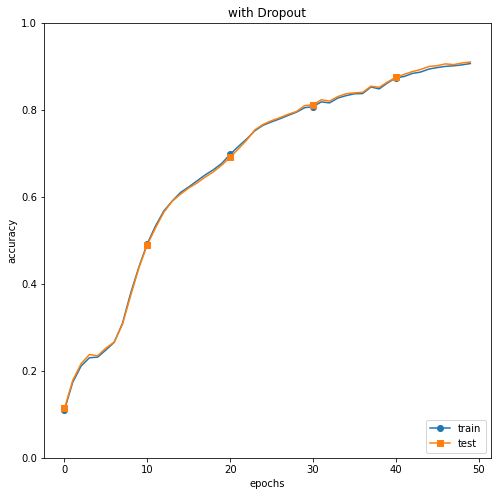

In [18]:
# 드롭아웃 사용  -> 훈련속도가 느림(망을 강제로 단순화 시킴) but 꾸준히 증가함 / 오버피팅 보이지 않는듯
# DOnetwork = MultiLayerNetExtend(input_size, hidden_size_list, output_size, activation='relu', weight_init_std='relu', weight_decay_lambda=0, use_dropout = True, dropout_ration = 0.5, use_batchnorm=False)
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.figure(figsize=(8,8))
plt.title("with Dropout")
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

train data를 이용하여 parameter를 최적화 한후,
validation data를 이용하여 hyper-parameter를 최적화 하자!
이후, test data를 이용하여 최종 정확도를 얻는다.

hyper-parameter -> 가중치 감소 정도/ 드롭아웃 퍼센트/ 배치 정규화 / learning rate ..